In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from torch.utils import data

In [194]:
iris = load_iris()
print(iris.keys())

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])


In [195]:
dataset = iris['data']
dataset.size

600

In [196]:
#print(data)

In [197]:
splitdata = np.split(dataset, [120])
print(type(splitdata))

<class 'list'>


In [198]:
#print(splitdata[0])

In [199]:
print("Trainset flattened size: {}, Rows: {}, Columns: {}".format(splitdata[0].size, splitdata[0].shape[0], splitdata[0].shape[1]))

Trainset flattened size: 480, Rows: 120, Columns: 4


In [200]:
REPLACE_COUNT = 60
NAN = 0

mdata = splitdata[0].copy()
mdata.flat[np.random.choice(mdata.size, REPLACE_COUNT, replace=False)] = NAN

testdata = splitdata[1].copy()
testdata.flat[np.random.choice(testdata.size, int(REPLACE_COUNT*0.2), replace=False)] = NAN
print(mdata)

[[5.1 3.5 0.  0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  0.  1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [0.  3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [0.  3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0. ]
 [5.7 4.4 1.5 0. ]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 0.  0.  0. ]
 [0.  3.8 1.5 0.3]
 [5.4 3.4 1.7 0. ]
 [5.1 3.7 1.5 0. ]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 0.  0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 0.  0.2]
 [5.  0.  1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 0.  0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  0.  1.6 0.6]
 [0.  3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 0.  0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [5.  3.3 1.4 0.2]
 [7.  3.2 0.  1.4]
 [0.  3.2 4.5 1.5]
 [6.9 0.  4.

In [201]:
# y_train = splitdata[0].copy()

# x_train = mdata.copy()

# y_test = splitdata[1].copy()

# x_test = testdata.copy()


y_train = torch.from_numpy(splitdata[0])
y_train = y_train.view(1, 120, 4)

x_train = torch.from_numpy(mdata)
x_train = x_train.view(1, 120, 4)

y_test = torch.from_numpy(splitdata[1])
y_test = y_test.view(1, 30, 4)

x_test = torch.from_numpy(testdata)
x_test = x_test.view(1, 30, 4)
print(x_train.shape)

torch.Size([1, 120, 4])


In [202]:
print("Trainset flattened size: {}, Rows: {}, Columns: {}".format(mdata.size, mdata.shape[0], mdata.shape[1]))
print("Target flattened size: {}, Rows: {}, Columns: {}".format(y_train.size, y_train.shape[0], y_train.shape[1]))
print("Testset flattened size: {}, Rows: {}, Columns: {}".format(x_test.size, x_test.shape[0], x_test.shape[1]))
print("Target Test flattened size: {}, Rows: {}, Columns: {}".format(y_test.size, y_test.shape[0], y_test.shape[1]))

Trainset flattened size: 480, Rows: 120, Columns: 4
Target flattened size: <built-in method size of Tensor object at 0x000002ADBF313438>, Rows: 1, Columns: 120
Testset flattened size: <built-in method size of Tensor object at 0x000002ADBF269D80>, Rows: 1, Columns: 30
Target Test flattened size: <built-in method size of Tensor object at 0x000002ADBF313F78>, Rows: 1, Columns: 30


In [203]:
from skorch import NeuralNetRegressor

In [204]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.enc1 = nn.Linear(in_features=4, out_features=3)
        self.enc2 = nn.Linear(in_features=3, out_features=2)

        self.dec1 = nn.Linear(in_features=2, out_features=3)
        self.dec2 = nn.Linear(in_features=3, out_features=4)

    
    def forward(self, x):
        x = F.leaky_relu(self.enc1(x))
        x = F.leaky_relu(self.enc2(x))
        x = F.leaky_relu(self.dec1(x))
        x = self.dec2(x)
        return x


In [205]:
net = Autoencoder().double()
print(net)

Autoencoder(
  (enc1): Linear(in_features=4, out_features=3, bias=True)
  (enc2): Linear(in_features=3, out_features=2, bias=True)
  (dec1): Linear(in_features=2, out_features=3, bias=True)
  (dec2): Linear(in_features=3, out_features=4, bias=True)
)


In [193]:
net = NeuralNetRegressor(
    Autoencoder().double(),
    max_epochs=500,
    lr=LEARNING_RATE,
    device='cuda',
    criterion=nn.MSELoss,
    optimizer = optim.Adam,
)
print(net)

<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=Autoencoder(
    (enc1): Linear(in_features=4, out_features=3, bias=True)
    (enc2): Linear(in_features=3, out_features=2, bias=True)
    (dec1): Linear(in_features=2, out_features=3, bias=True)
    (dec2): Linear(in_features=3, out_features=4, bias=True)
  ),
)


In [194]:
#net.fit(x_train, y_train)

In [206]:
NUM_EPOCHS = 6000
LEARNING_RATE = 0.01
BATCH_SIZE = 120

In [207]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
print(len(x_train))

1


In [208]:
def train(net):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data, labels in zip(x_train, y_train):
            optimizer.zero_grad()
            outputs = net(data.double())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if epoch == NUM_EPOCHS-1:
                for i in range(len(data)):
                    print("Input: ", data[i])
                    print("Target: ", labels[i])
                    print("Outputs: ", outputs[i])
        loss = running_loss / len(x_train)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'
            .format(epoch+1, NUM_EPOCHS, loss))
    return train_loss

def test(net):

    net.eval()

    with torch.no_grad():
        test_loss = []
        running_loss = 0.0
        for data, labels in zip(x_test, y_test):
            outputs = net(data.double())
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            for i in range(len(data)):
                print("Input: ", data[i])
                print("Target: ", labels[i])
                print("Outputs: ", outputs[i])
        loss = running_loss / len(x_test)
        test_loss.append(loss)
        print('Test Loss: {:.3f}'.format(loss))

        return test_loss
        

In [209]:
train_loss1 = train(net)


dtype=torch.float64,
       grad_fn=<SelectBackward>)
Input:  tensor([5.1000, 3.4000, 0.0000, 0.2000], dtype=torch.float64)
Target:  tensor([5.1000, 3.4000, 1.5000, 0.2000], dtype=torch.float64)
Outputs:  tensor([5.3195, 3.4625, 1.6914, 0.2911], dtype=torch.float64,
       grad_fn=<SelectBackward>)
Input:  tensor([5.0000, 3.5000, 1.3000, 0.3000], dtype=torch.float64)
Target:  tensor([5.0000, 3.5000, 1.3000, 0.3000], dtype=torch.float64)
Outputs:  tensor([4.9656, 3.3986, 1.2953, 0.1574], dtype=torch.float64,
       grad_fn=<SelectBackward>)
Input:  tensor([4.5000, 2.3000, 1.3000, 0.3000], dtype=torch.float64)
Target:  tensor([4.5000, 2.3000, 1.3000, 0.3000], dtype=torch.float64)
Outputs:  tensor([4.5119, 3.1230, 1.3250, 0.2332], dtype=torch.float64,
       grad_fn=<SelectBackward>)
Input:  tensor([4.4000, 3.2000, 1.3000, 0.2000], dtype=torch.float64)
Target:  tensor([4.4000, 3.2000, 1.3000, 0.2000], dtype=torch.float64)
Outputs:  tensor([4.4383, 3.0885, 1.3014, 0.2324], dtype=torch.floa

Text(0, 0.5, 'Loss')

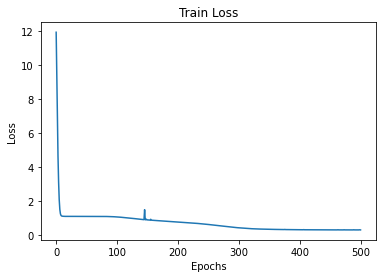

In [53]:
plt.figure()
plt.plot(train_loss1)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [210]:
test_result = test(net)

Input:  tensor([6.9000, 3.2000, 5.7000, 2.3000], dtype=torch.float64)
Target:  tensor([6.9000, 3.2000, 5.7000, 2.3000], dtype=torch.float64)
Outputs:  tensor([6.8570, 2.9360, 5.6496, 1.8968], dtype=torch.float64)
Input:  tensor([5.6000, 0.0000, 4.9000, 2.0000], dtype=torch.float64)
Target:  tensor([5.6000, 2.8000, 4.9000, 2.0000], dtype=torch.float64)
Outputs:  tensor([5.6345, 2.4775, 4.9404, 1.7386], dtype=torch.float64)
Input:  tensor([7.7000, 2.8000, 6.7000, 0.0000], dtype=torch.float64)
Target:  tensor([7.7000, 2.8000, 6.7000, 2.0000], dtype=torch.float64)
Outputs:  tensor([7.4058, 2.8527, 6.7711, 2.3369], dtype=torch.float64)
Input:  tensor([6.3000, 2.7000, 4.9000, 1.8000], dtype=torch.float64)
Target:  tensor([6.3000, 2.7000, 4.9000, 1.8000], dtype=torch.float64)
Outputs:  tensor([6.2785, 2.8801, 4.8666, 1.6164], dtype=torch.float64)
Input:  tensor([6.7000, 3.3000, 5.7000, 2.1000], dtype=torch.float64)
Target:  tensor([6.7000, 3.3000, 5.7000, 2.1000], dtype=torch.float64)
Outputs

In [211]:
torch.save(net, './iris_autoencoder')

In [212]:
load_model = torch.load('iris_autoencoder')
load_model

Autoencoder(
  (enc1): Linear(in_features=4, out_features=3, bias=True)
  (enc2): Linear(in_features=3, out_features=2, bias=True)
  (dec1): Linear(in_features=2, out_features=3, bias=True)
  (dec2): Linear(in_features=3, out_features=4, bias=True)
)

In [213]:
criterion = nn.MSELoss()
optimizer = optim.Adam(load_model.parameters(), lr=LEARNING_RATE)
print(len(x_train))

1


In [214]:
test_result = test(load_model)

Input:  tensor([6.9000, 3.2000, 5.7000, 2.3000], dtype=torch.float64)
Target:  tensor([6.9000, 3.2000, 5.7000, 2.3000], dtype=torch.float64)
Outputs:  tensor([6.8570, 2.9360, 5.6496, 1.8968], dtype=torch.float64)
Input:  tensor([5.6000, 0.0000, 4.9000, 2.0000], dtype=torch.float64)
Target:  tensor([5.6000, 2.8000, 4.9000, 2.0000], dtype=torch.float64)
Outputs:  tensor([5.6345, 2.4775, 4.9404, 1.7386], dtype=torch.float64)
Input:  tensor([7.7000, 2.8000, 6.7000, 0.0000], dtype=torch.float64)
Target:  tensor([7.7000, 2.8000, 6.7000, 2.0000], dtype=torch.float64)
Outputs:  tensor([7.4058, 2.8527, 6.7711, 2.3369], dtype=torch.float64)
Input:  tensor([6.3000, 2.7000, 4.9000, 1.8000], dtype=torch.float64)
Target:  tensor([6.3000, 2.7000, 4.9000, 1.8000], dtype=torch.float64)
Outputs:  tensor([6.2785, 2.8801, 4.8666, 1.6164], dtype=torch.float64)
Input:  tensor([6.7000, 3.3000, 5.7000, 2.1000], dtype=torch.float64)
Target:  tensor([6.7000, 3.3000, 5.7000, 2.1000], dtype=torch.float64)
Outputs

In [245]:
iris = load_iris()
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [246]:
extracted_data = iris['data']
extracted_data.shape

(150, 4)

In [247]:
REPLACE_COUNT = 60
NAN = 0

extracted_data.flat[np.random.choice(extracted_data.size, REPLACE_COUNT, replace=False)] = NAN

dataset = torch.from_numpy(extracted_data)
dataset.view(1, 150, 4)

tensor([[[5.1000, 0.0000, 1.4000, 0.2000],
         [4.9000, 3.0000, 1.4000, 0.2000],
         [4.7000, 0.0000, 1.3000, 0.0000],
         [4.6000, 3.1000, 0.0000, 0.2000],
         [5.0000, 3.6000, 1.4000, 0.2000],
         [5.4000, 3.9000, 1.7000, 0.0000],
         [4.6000, 3.4000, 1.4000, 0.3000],
         [5.0000, 3.4000, 1.5000, 0.2000],
         [4.4000, 2.9000, 1.4000, 0.2000],
         [4.9000, 3.1000, 1.5000, 0.1000],
         [5.4000, 0.0000, 1.5000, 0.2000],
         [4.8000, 3.4000, 1.6000, 0.2000],
         [4.8000, 3.0000, 1.4000, 0.1000],
         [4.3000, 3.0000, 0.0000, 0.1000],
         [5.8000, 4.0000, 1.2000, 0.2000],
         [5.7000, 4.4000, 1.5000, 0.4000],
         [5.4000, 3.9000, 1.3000, 0.4000],
         [5.1000, 3.5000, 1.4000, 0.3000],
         [5.7000, 0.0000, 0.0000, 0.3000],
         [5.1000, 3.8000, 0.0000, 0.3000],
         [5.4000, 3.4000, 1.7000, 0.2000],
         [5.1000, 3.7000, 1.5000, 0.4000],
         [4.6000, 3.6000, 1.0000, 0.2000],
         [5

In [248]:
new_dataset = load_model(dataset.double())

In [249]:
torch.set_printoptions(precision=4, sci_mode=False)
new_dataset

tensor([[5.0635, 3.3650, 1.5488, 0.2582],
        [4.8677, 3.3130, 1.3759, 0.2056],
        [4.6328, 3.1832, 1.3552, 0.2283],
        [5.0432, 3.5414, 1.0260, 0.0207],
        [4.9644, 3.3752, 1.3598, 0.1850],
        [5.3086, 3.4665, 1.6645, 0.2778],
        [4.6187, 3.1710, 1.3665, 0.2355],
        [4.9653, 3.3380, 1.4645, 0.2330],
        [4.4341, 3.0584, 1.3796, 0.2668],
        [4.8704, 3.2799, 1.4721, 0.2495],
        [5.3424, 3.4568, 1.7463, 0.3107],
        [4.7969, 3.2038, 1.5643, 0.3019],
        [4.7780, 3.2607, 1.3756, 0.2178],
        [4.6642, 3.3408, 0.9697, 0.0470],
        [5.3704, 3.4535, 1.8006, 0.3319],
        [5.3483, 3.4580, 1.7525, 0.3128],
        [5.2019, 3.4991, 1.4008, 0.1712],
        [5.0524, 3.4255, 1.3628, 0.1743],
        [5.9576, 3.2892, 3.2094, 0.8988],
        [5.3277, 3.4676, 1.6923, 0.2879],
        [5.3118, 3.4655, 1.6724, 0.2810],
        [5.0635, 3.3980, 1.4573, 0.2162],
        [4.6009, 3.3052, 0.9647, 0.0533],
        [5.0520, 3.3166, 1.6647, 0

In [250]:
np.savetxt('first_iris.csv', new_dataset.detach().numpy())